# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [46]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

import datetime
from scipy.io import loadmat
from sklearn import metrics


%matplotlib inline
%config InlineBackend.figure_format='retina'
'''
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')
'''
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


In [47]:
df = pd.read_csv('./trainset/J0003_0024_0222_20110307012737_cell_1.csv')

df['일자'] = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
df['연도'] =df['일자'].dt.year
df['월'] =df['일자'].dt.month
df['일'] =df['일자'].dt.day

In [48]:
df.tail(5)

,CellNo,Resistance,Volt,Temp,일자,연도,월,일
254,1,0.301,2.23,-20,2011-08-30 05:28:00,2011,8,30
255,1,0.301,2.23,-20,2011-08-30 17:28:00,2011,8,30
256,1,0.302,2.23,-20,2011-08-31 05:28:00,2011,8,31
257,1,0.300,2.23,-20,2011-08-31 16:09:00,2011,8,31
258,1,0.296,2.23,-20,2011-08-31 16:12:00,2011,8,31


In [49]:
xcolumn = ['Resistance','Volt','Temp']
ycolumn = ['Resistance']

#x = df[xcolumn]
#y = df[ycolumn]
'''
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler(feature_range=(0,1))
# X scaler 생성
xscaler = scaler.fit(x)
# Y scaler 생성
yscaler = scaler.fit(y)

# 스케일링 적용
trainX = xscaler.transform(x)
trainY = yscaler.transform(y)

#df_scaled = scaler.fit_transform(df[scale_cols])
'''
scaler = MinMaxScaler()
scale_cols = ['Resistance','Volt','Temp']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)

df_scaled.columns = scale_cols

dataX = df_scaled[xcolumn]
dataY = df_scaled[ycolumn]

dataX = pd.DataFrame(dataX)
dataY = pd.DataFrame(dataY)
#trainX.columns = xcolumn
#trainY.columns = ycolumn

print(dataX.tail())
print('----')
print(dataY.tail())

     Resistance  Volt  Temp
254    0.977273   0.0   0.0
255    0.977273   0.0   0.0
256    1.000000   0.0   0.0
257    0.954545   0.0   0.0
258    0.863636   0.0   0.0
----
     Resistance
254    0.977273
255    0.977273
256    1.000000
257    0.954545
258    0.863636


(259, 3)


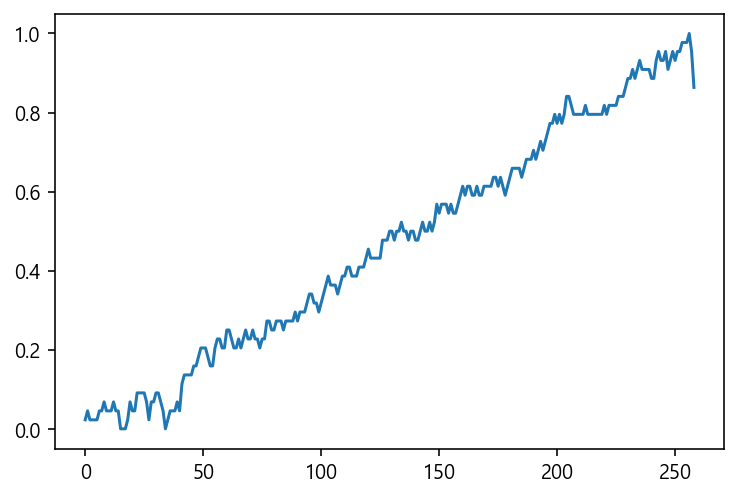

In [50]:
'''
test_data_size = 30

train_data = dataset[:-test_data_size]
test_data = dataset[-test_data_size:]
'''
#sohs = ['time']
#trainX = df_scaled[xcolumn]
#trainY = df_scaled[ycolumn]

print(dataX.shape)
plt.plot(dataY)
plt.show()

In [51]:
def create_sequences1(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

seq_length = 4


In [52]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(dataX, dataY, test_size=0.2)

In [53]:
x_train = np.array(x_train)
y_train= np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

print("train set : ", x_train.shape)
print("test set : ", x_valid.shape)

train set :  (207, 3)
test set :  (52, 3)


In [94]:
x = create_sequences1(dataX, seq_length)
y = create_sequences1(dataY, seq_length)
x_train = create_sequences1(x_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
x_test = create_sequences1(x_valid, seq_length)
y_test = create_sequences1(y_valid, seq_length)

x= np.array(x)
y=np.array(y)

ValueError: only one element tensors can be converted to Python scalars

In [87]:
from torch.autograd import Variable

print(dataX.type())
'''
dataX = Variable(torch.Tensor(np.array(dataX)))
dataY = Variable(torch.Tensor(np.array(dataY)))

x_train = Variable(torch.Tensor(np.array(x_train)))
y_train= Variable(torch.Tensor(np.array(y_train)))

x_test = Variable(torch.Tensor(np.array(x_test)))
y_test = Variable(torch.Tensor(np.array(y_test)))
'''

torch.FloatTensor


'\ndataX = Variable(torch.Tensor(np.array(dataX)))\ndataY = Variable(torch.Tensor(np.array(dataY)))\n\nx_train = Variable(torch.Tensor(np.array(x_train)))\ny_train= Variable(torch.Tensor(np.array(y_train)))\n\nx_test = Variable(torch.Tensor(np.array(x_test)))\ny_test = Variable(torch.Tensor(np.array(y_test)))\n'

In [91]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [92]:
x_train.type() 

AttributeError: 'list' object has no attribute 'type'

In [93]:
num_epochs = 200
learning_rate = 0.01

input_size = 3
hidden_size = 2
num_layers = 2

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(x_train)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

AttributeError: 'list' object has no attribute 'size'

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()